In [16]:
import pandas as pd
import numpy as np
import jieba.posseg as psg
import re

In [17]:
# 加载评论内容
words = pd.read_csv('./storage-评论内容.csv',encoding="utf-8")

#  情感分类

In [18]:
# 读入正面、负面情感评价词
pos_comment = pd.read_csv("./正面评价词语（中文）1.txt", header=None,sep="\n", 
                          encoding = 'utf-8', engine='python')
neg_comment = pd.read_csv("./负面评价词语（中文）1.txt", header=None,sep="\n", 
                          encoding = 'utf-8', engine='python')
pos_emotion = pd.read_csv("./正面情感词语（中文）1.txt", header=None,sep="\n", 
                          encoding = 'utf-8', engine='python')
neg_emotion = pd.read_csv("./负面情感词语（中文）1.txt", header=None,sep="\n", 
                          encoding = 'utf-8', engine='python')

# 合并情感词与评价词
positive = set(pos_comment.iloc[:,0])|set(pos_emotion.iloc[:,0])
negative = set(neg_comment.iloc[:,0])|set(neg_emotion.iloc[:,0])
# 正负面情感词表中相同的词语
intersection = positive & negative  
# 去掉相同的词
positive = list(positive - intersection)
negative = list(negative - intersection)

# 正面词语赋予初始权重1，负面词语赋予初始权重-1
positive = pd.DataFrame({"word":positive,
                         "weight":[1]*len(positive)})
negative = pd.DataFrame({"word":negative,
                         "weight":[-1]*len(negative)})
posneg = positive.append(negative)
# 将分词结果与正负面情感词表合并，定位情感词
data_posneg = pd.merge(left=words,right=posneg,on='word',how='left')
# 先按评论id排序，再按在评论中的位置排序
data_posneg = data_posneg.sort_values(by = ['index_content','index_word'])
data_posneg.head(10)


,index_content,word,nature,content_type,index_word,weight
0,0,疫情,n,5.0,0,NaN
1,0,沪,j,5.0,1,NaN
2,0,周末,t,5.0,2,NaN
3,0,住,v,5.0,3,NaN
4,0,住,v,5.0,4,NaN
5,0,订,v,5.0,5,NaN
6,0,大床,nz,5.0,6,NaN
7,0,房,n,5.0,7,NaN
8,0,免费,vn,5.0,8,1.0
9,0,升级成,l,5.0,9,NaN


In [19]:
# 根据情感词前面两个位置的词语是否存在否定词或双层否定词对情感值进行修正
# 载入否定词表
notdict = pd.read_csv("./否定词.txt")
notdict=dict()
#notdict.setdefault('term','')
# 处理否定修饰词
# 构造新列，作为经过否定词修正后的情感值
data_posneg['amend_weight'] = data_posneg['weight'] 
data_posneg['id'] = np.arange(0, len(data_posneg))
# 只保留有情感值的词语
only_inclination = data_posneg.dropna()  
# 修改索引
only_inclination.index = np.arange(0, len(only_inclination))
print(only_inclination)

      index_content word nature  content_type  index_word  weight  \
0                 0   免费     vn           5.0           8     1.0   
1                 0    新      a           5.0          29     1.0   
2                 0   智能      n           5.0          34     1.0   
3                 0   免费     vn           5.0          39     1.0   
4                 0   免费     vn           5.0          44     1.0   
...             ...  ...    ...           ...         ...     ...   
8161           2827   舒适      a           5.0           4     1.0   
8162           2827   免费     vn           5.0           6     1.0   
8163           2827   惊喜      a           5.0           9     1.0   
8164           2827   满意      v           5.0          18     1.0   
8165           2827   推荐      v           5.0          20     1.0   

      amend_weight      id  
0              1.0       8  
1              1.0      29  
2              1.0      34  
3              1.0      39  
4              1.0      44

In [20]:
index = only_inclination['id']
for i in np.arange(0, len(only_inclination)):
    # 提取第i个情感词所在的评论
    review = data_posneg[data_posneg['index_content'] == only_inclination['index_content'][i]]  
    # 修改索引
    review.index = np.arange(0, len(review))
    # 第i个情感值在该文档的位置
    affective = only_inclination['index_word'][i]  
    if affective == 1:
        # 情感词前面的单词是否在否定词表
        ne = sum([i in notdict for i in review['word'][affective - 1]])
        
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -data_posneg['weight'][index[i]]          
    elif affective > 1:
        # 情感词前面两个位置的词语是否在否定词，存在一个调整成相反的情感权重，存在两个就不调整
        ne = sum([i in notdict for i in review['word'][[affective - 1, affective - 2]]])
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -data_posneg['weight'][index[i]]

In [21]:
# 计算每条评论的情感值
emotional_value = only_inclination.groupby(['index_content'],as_index=False)['amend_weight'].sum()
# 去除情感值为0的评论
emotional_value = emotional_value[emotional_value['amend_weight'] != 0]
emotional_value.reset_index(drop=True,inplace=True)
print(emotional_value)

      index_content  amend_weight
0                 0           5.0
1                 1           3.0
2                 2          -6.0
3                 3          -7.0
4                 4           7.0
...             ...           ...
2397           2823           7.0
2398           2824           1.0
2399           2825           1.0
2400           2826           2.0
2401           2827           7.0

[2402 rows x 2 columns]


In [22]:
# 给情感值大于0的赋予评论类型pos，小于0的赋予neg
emotional_value['a_type'] = ''
emotional_value['a_type'][emotional_value['amend_weight'] > 0] = 'pos'
emotional_value['a_type'][emotional_value['amend_weight'] < 0] = 'neg'
# 查看情感分析的结果
result = pd.merge(left=words,right=emotional_value,on='index_content',how='right')

<ipython-input-22-1d3afc714662>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotional_value['a_type'][emotional_value['amend_weight'] > 0] = 'pos'
<ipython-input-22-1d3afc714662>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotional_value['a_type'][emotional_value['amend_weight'] < 0] = 'neg'


In [23]:
# 去重
result = result[['index_content','content_type', 'a_type']].drop_duplicates() 
result.head()

,index_content,content_type,a_type
0,0,5.0,pos
59,1,5.0,pos
90,2,2.5,neg
133,3,1.2,neg
272,4,5.0,pos


In [24]:
# 混淆矩阵-交叉表
confusion_matrix = pd.crosstab(result['content_type'],result['a_type'],margins=True)
print(confusion_matrix)


a_type        neg   pos   All
content_type                 
1.0            31    12    43
1.2             2     2     4
1.5             3     1     4
1.7             1     1     2
2.0             4     7    11
2.2             1     3     4
2.5            11     9    20
2.7             1     5     6
3.0             7    16    23
3.2             5    14    19
3.5             9    14    23
3.7            13    18    31
4.0            13    90   103
4.2             2    27    29
4.5             9    68    77
4.7             8   108   116
5.0            40  1847  1887
All           160  2242  2402


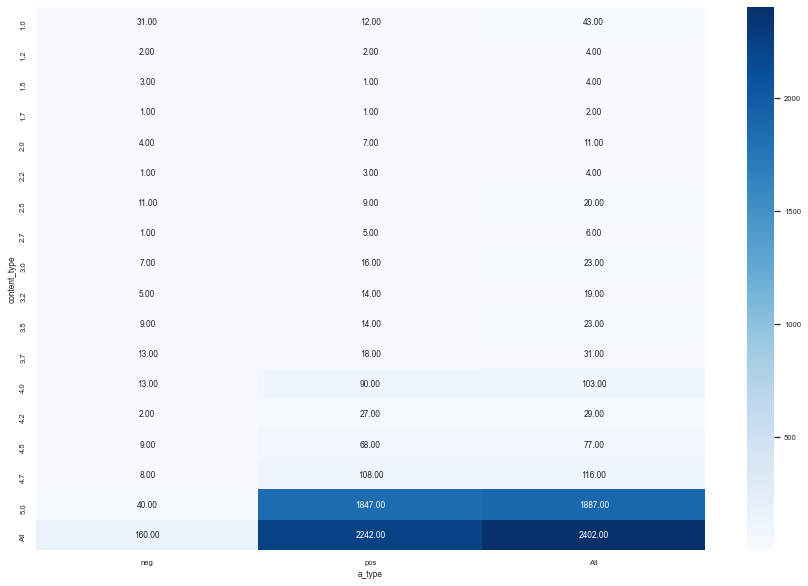

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

#计算图例的max与min
maxi = confusion_matrix.values.max()
mini = confusion_matrix.values.min()

sns.set(font_scale = 0.7)
#设置画布
plt.figure(figsize = (15,10))
#热力图绘制
sns.heatmap(confusion_matrix, vmax = maxi, vmin = mini, annot = True, cmap = 'Blues', fmt = '.2f')
plt.show()

In [26]:
# 提取正负面评论信息
# 得到正面评论与负面评论对应的索引
ind_pos = list(emotional_value[emotional_value['a_type'] == 'pos']['index_content'])
ind_neg = list(emotional_value[emotional_value['a_type'] == 'neg']['index_content'])
# 得到正面评论与负面评论
posdata = words[[i in ind_pos for i in words['index_content']]]
negdata = words[[i in ind_neg for i in words['index_content']]]

# 绘制情感词云

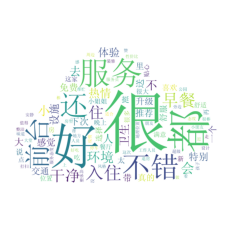

In [27]:
# 绘制正面情感词云
# 正面情感词词云
freq_pos = posdata.groupby(by = ['word'])['word'].count()
freq_pos = freq_pos.sort_values(ascending = False)
backgroud_Image=plt.imread('./cloud.jpg')
wordcloud = WordCloud(font_path="D:\college\大二下\数据科学导论\期末提交\codes\《crawl-preprocess-storage》\source\simsun.ttf",#字体
                      max_words=100,
                      background_color='white',
                      mask=backgroud_Image)
pos_wordcloud = wordcloud.fit_words(freq_pos)
plt.imshow(pos_wordcloud)
plt.axis('off') 
#plt.show()
# 将图片导出
plt.savefig("pos_cloud.png", dpi=500, bbox_inches='tight')


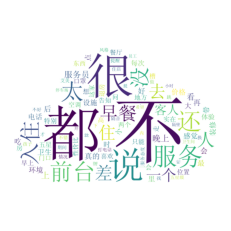

In [28]:
# 绘制负面评论词云
freq_neg = negdata.groupby(by = ['word'])['word'].count()
freq_neg = freq_neg.sort_values(ascending = False)
neg_wordcloud = wordcloud.fit_words(freq_neg)
plt.imshow(neg_wordcloud)
plt.axis('off') 
plt.savefig("neg_cloud.png", dpi=500, bbox_inches='tight')


In [29]:
# 分别储存正面、负面评论,评论中的每个分词作为一行
posdata.to_csv("posdata.csv", index = False, encoding = 'utf-8')
negdata.to_csv("negdata.csv", index = False, encoding = 'utf-8')
